In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df_test = pd.read_parquet('E:/Phat/imbalance/df_test.parquet')
df_train  = pd.read_parquet('E:/Phat/imbalance/df_train.parquet')

In [3]:
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang_year',
    'ngay_hhluc_khang_month',
    'ngay_hhluc_khang_day',
    'ngay_hhluc_vitri_ddo_year',
    'ngay_hhluc_vitri_ddo_month',
    'ngay_hhluc_vitri_ddo_day',
    'ngay_hhluc_diemdo_year',
    'ngay_hhluc_diemdo_month',
    'ngay_hhluc_diemdo_day',
    'ngay_hluc_diem_do_year',
    'ngay_hluc_diem_do_month',
    'ngay_hluc_diem_do_day',
    'loai_chiso',
    'ngay_hluc_diem_do_year',
    'ngay_hluc_diem_do_month',
    'ngay_hluc_diem_do_day',
    'ngay_hluc_vitri_ddo_year',
    'ngay_hluc_vitri_ddo_month',
    'ngay_hluc_vitri_ddo_day',
    'thang_csuat_ddo',
    'ngay_hluc_khang_year',
    'ngay_hluc_khang_month',
    'ngay_hluc_khang_day',
    'gia_tri',
    'loai_giatri',
    'ma_dviqly',
    'so_cot',
    'so_hop',
    'ma_dvictren',
    'ky',
    'thang',
    'nam',
    'sluong_ttiep',
    'sluong_trphu',
    'thd_le',
    'ma_cnang_chiso',
    'id_khang',
    'ngay_tao_chiso_year',
    'ngay_tao_chiso_month',
    'ngay_tao_chiso_day',
    'nguoi_tao_chiso',
    'ngay_sua_chiso_year',
    'ngay_sua_chiso_month',
    'ngay_sua_chiso_day',
    'nguoi_sua_chiso',
]
target = 'fraud'

X = df_train.drop(columns=cols_to_drop)
y = df_train['fraud']

[Text(0, 0.5, '4379498'), Text(0, 0.5, '56163')]

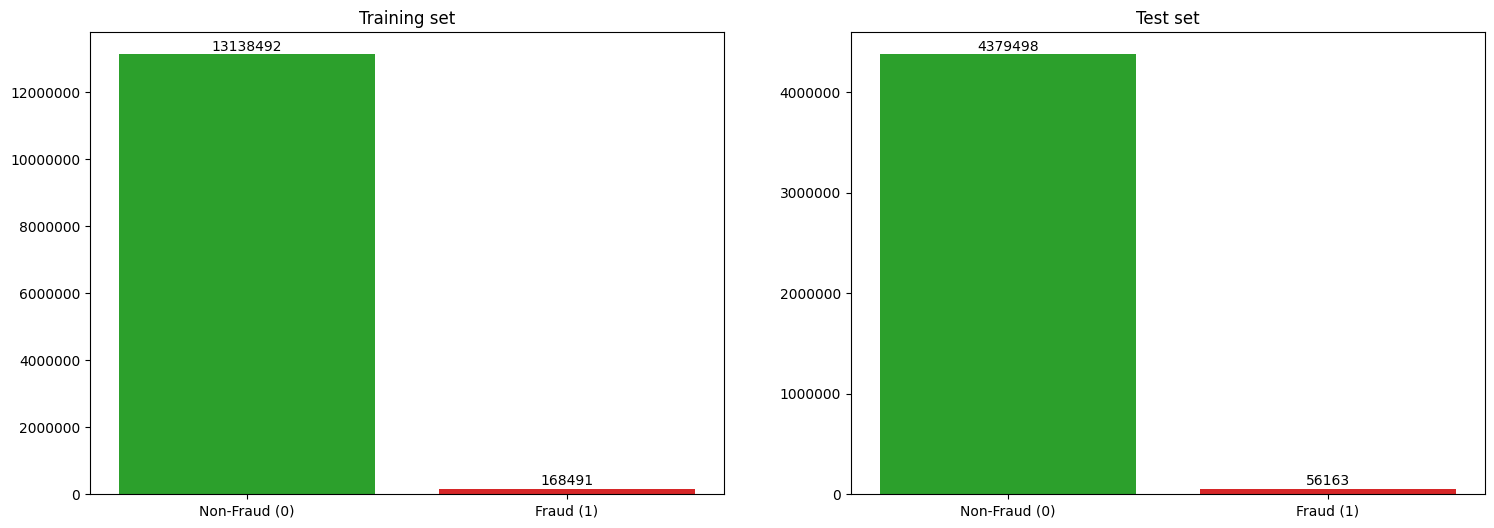

In [4]:
import matplotlib.pyplot as plt

# Tinh so luong  fraud va nonfraud trong 3 tap train, test va validation
non_fraud_train, fraud_train = df_train[target].value_counts()
non_fraud_test, fraud_test = df_test[target].value_counts()
# non_fraud_valid, fraud_valid = df_valid.value_counts()

# Ve bieu do bar chart the hien so luong fraud va non fraud
x = ['Non-Fraud (0)', 'Fraud (1)']
y1 = [non_fraud_train, fraud_train]
y2 = [non_fraud_test, fraud_test]
# y3 = [non_fraud_valid, fraud_valid]
bar_color = ['tab:green','tab:red']

fig, axs = plt.subplots(1,2, figsize=(18,6))

bar1 = axs[0].bar(x, y1, color=bar_color)
axs[0].set_title('Training set')
axs[0].ticklabel_format(style='plain', axis='y')
axs[0].bar_label(bar1, padding= 0.5, fmt = '{:.0f}')

bar2 = axs[1].bar(x, y2, color=bar_color)
axs[1].set_title('Test set')
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].bar_label(bar2, padding= 0.5, fmt = '{:.0f}')

# bar3 = axs[2].bar(x, y3, color=bar_color)
# axs[2].set_title('Validation set')
# axs[2].ticklabel_format(style='plain', axis='y')
# axs[2].bar_label(bar3, padding= 0.5, fmt = '{:.0f}')



# CatBoost

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc


In [6]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

SEED = 42
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    # 'cat_features':      cat_cols,
}


# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Khởi tạo mô hình CatBoost với các siêu tham số tốt nhất
model = CatBoostClassifier(**cb_params)

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    model,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
model.fit(X, y)


Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19860642 0.19864923 0.19871348 0.19866549 0.19868938]
Mean pAUC: 0.1987, Std: 0.0000
Training final model on the entire combined dataset...


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   4379498
           1       0.60      0.96      0.74     56163

    accuracy                           0.99   4435661
   macro avg       0.80      0.98      0.87   4435661
weighted avg       0.99      0.99      0.99   4435661



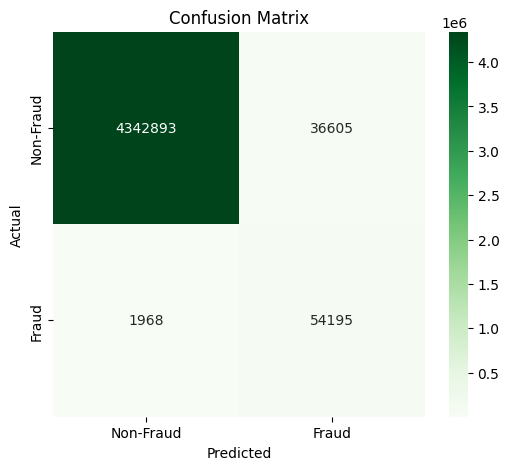

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_test = df_test.drop(columns=[target])
y_test = df_test[target]

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [8]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')


Custom pAUC Score: 0.1986540138032991
AUC Score: 0.9979883528328779


Text(0, 0.5, 'True Positive Rate')

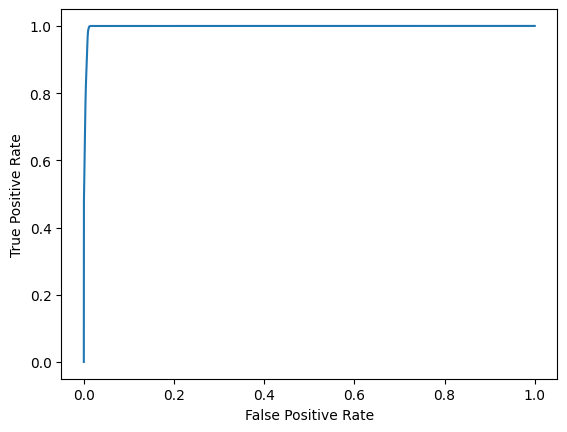

In [9]:
# Ve ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

C:\Users\HOME\AppData\Local\Temp\ipykernel_8860\514575069.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


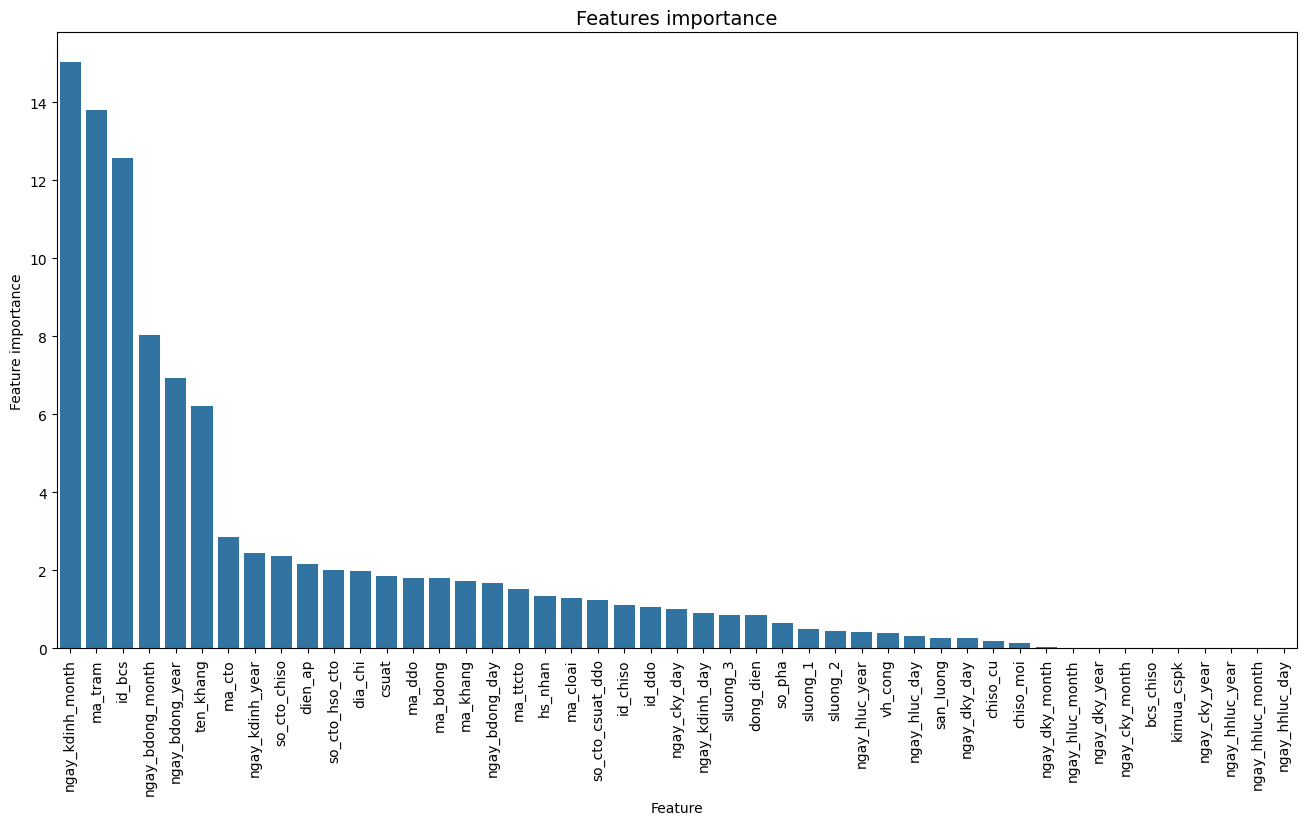

In [10]:
Features = [col for col in df_train.columns if col not in cols_to_drop]
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()